# Image Classification with PyTorch: AlexNet

[Pablo Carballeira] (http://dymas.ii.uam.es/webvpu/gti/user/186/), Escuela Politecnica Superior, Universidad Autónoma de Madrid.

Parts of this code have been adapted from then work of Kevin McGuinness (http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University, and the work of Ben Trevett (https://github.com/bentrevett), Heriot-Watt University

You can find documentation about working in Colab here (https://colab.research.google.com/notebooks/intro.ipynb)

---

In this lab assignment you will learn how to use the [PyTorch](https://pytorch.org/) deep learning framework to create and train a modified version of the AlexNet model and a simplified ResNet model for image classification. You will use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset that contains 10 classes of color images

# Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

# Import packages

Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and check that *GPU* is selected under hardware accelerator.


In [ ]:
# make sure to enable GPU acceleration!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We set the random seed so all of our experiments can be reproduced.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset: CIFAR10

We are now moving on from the MNIST dataset and we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)



# Dataset pre-processing


## Mean and standard deviation of the dataset

As mentioned in the previous notebook, for those models that do not use early batch normalization, it is important to transform the dataset so that the images have mean zero and unit variance. 

Here, we calculate the mean and standard deviation of our data so we can normalize it appropiately. CIFAR10 is made up of color images with three color channels (red, green and blue). To normalize the data we need to calculate the means and standard deviations for each of the color channels independently. 



In [ ]:
ROOT = '.data/CIFAR10'

train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

# use the functions that are built in the dataset to obtain the means and stds. 
# Bear in mind that image pixels are in the [0,255] range, but they are converted to
# the [0,1] range when transformed to Tensor variables 
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/CIFAR10/cifar-10-python.tar.gz to .data/CIFAR10
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]



Next up is defining the transforms for the training and validation sets. 



In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# define the train and tesst transforms with normalization with the means and 
# stds we have just computed 
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

Next, as standard, we'll load the dataset with our transforms...

In [ ]:
train_set = datasets.CIFAR10(ROOT, train=True, transform=train_transform)
valid_set = datasets.CIFAR10(ROOT, train=False, transform=valid_transform)

We print out the number of examples in each set of data to ensure everything has gone OK so far.

In [ ]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(valid_set)}')

Number of training examples: 50000
Number of validation examples: 10000


## Dataset examples

We will use `matplotlib` to see some examples of the CIFAR10 dataset



`matplotlib` expects the values of every pixel to be between $[0, 1]$. However our normalization will cause them to be outside this range. A solution to this is to renormalize the images so each pixel is between $[0, 1]$, so we'll write a function that does it and we can use whenever we need to renormalize an image.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

Now, we'll create a function to plot some of the images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but `matplotlib` expects images to be `[height, width, channel]`, hence we need to `permute` our images before plotting them.

In [ ]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Then, we'll actually plot the images.

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's `classes` dictionary.

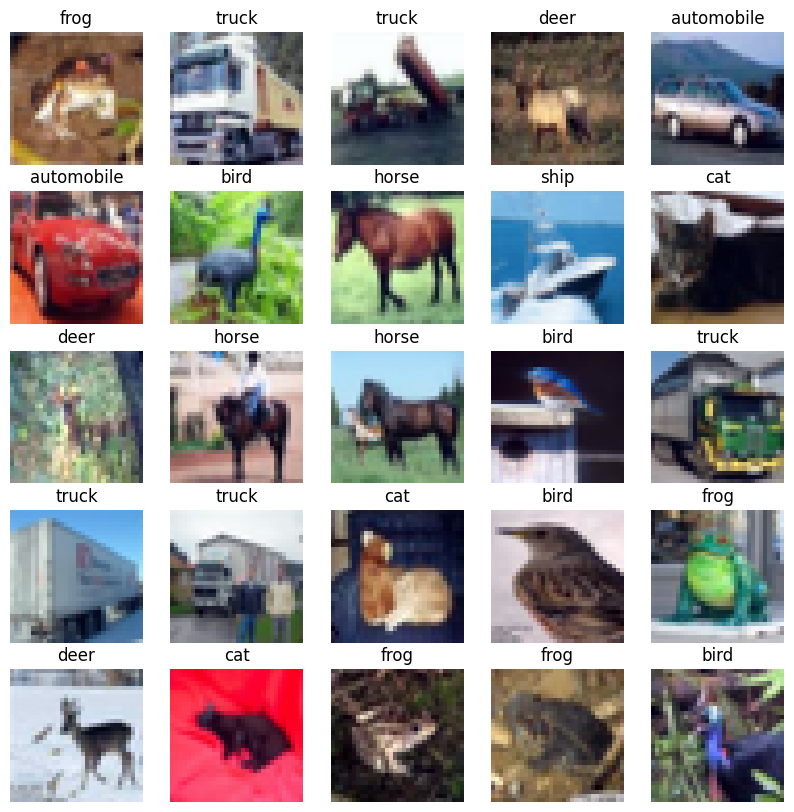

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_set[i] for i in range(N_IMAGES)]])
classes = valid_set.classes
plot_images(images, labels, classes, normalize = True)

The final bit of the data processing is creating the iterators.

We will use here a larger batch size. Generally, when using a GPU, a larger batch size means our model trains faster. Our model has significantly more parameters and the images it is training on are much larger, than the previous notebook, so will generally take longer. We offset this as much as we can by using a batch size of 256.

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

# AlexNet

In this notebook we will be implementing a modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the original architecture of AlexNet. There are two "paths" of processing through the network. This is due to the original AlexNet model being implemented on two GPUs in parallel. Almost all implementations of AlexNet are now on a single GPU and our implementation is too. In a single-GPU implementation, both paths are combined by doubling the number of feature channels in each layer (adds up the number of feature channels in each path)

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/alexnet.png?raw=1)



# Defining the Model

The AlexNet model itself is not conceptually very different from the simple CNN model of the previous notebook. It is made up of convolutional layers, pooling layers, ReLU activation functions and Dropout layers.

AlexNet was designed for ImageNet, that comprises 224x224 color images. Here, we are using 32x32 images of the CIFAR10 dataset, so we will adapt the original AlexNet architecture with the following modifications:

* the inputs are 32x32 color images
*  only one branch of the model will be implemented, so the layers will have half the number of channels than in the complete version (the complete version doubles the number of channels in a single branch)
*  5x5 kernels are used in the first conv layer, instead of the original 11x11 kernel size
* 2x2 max pooling kernels are used
*  Local Response Normalization layers are skipped 
*  Dropout with probability 0.5 is added before the first and second Linear layers



## Model definition: Sequential 

`Sequential` is used to compact the code for the definition of the network. We use `Sequential` to define the multiple layers of the CNN and when the `Sequential` module is called it will apply each layer, in order, to the input. There is no difference between using a `Sequential` and having each module defined in the `__init__` and then called in `forward` - however it makes the code significantly shorter.

We will create one `Sequential` model, `features`, for all the convolutional and pooling layers, then we flatten the data, and pass it to another `Sequential` model, `classifier`,  which is made up of linear layers. 


One last thing to mention is that the very first convolutional layer has an `in_channel` of three. That is because we are handling color images that have three channels (red, green and blue) instead of the single channel grayscale images from the MNIST dataset. This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.



Note that the model is defined with the number of output classes as a parameter (defined by the number of classes of the dataset)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            # First convolutional layer. Use 5x5 kernel instead of 11x11
            nn.Conv2d(3, 48, 5, 2, 2), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            # Complete the following four conv layers of the AlexNet model. 
            # Subsampling is only performed by 2x2 max pooling layers (not with stride in the 
            # convolutional layers)
            # Pay special attention to the number of input and output channels of each layer
            nn.Conv2d(48, 128, 5, padding=2),
            nn.MaxPool2d(2),    
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 192, 3, padding=1),  
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 192, 3, padding=1),  
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 128, 3, padding=1),  
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            # First linear layer
            nn.Dropout(0.5),
            nn.Linear(128 * 2 * 2, 2048), # final conv layer resolution 2x2
            nn.ReLU(inplace = True),
            # second linear layer
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(inplace=True),
            # Last Linear layer. No ReLU
            nn.Linear(2048, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        interm_features = x.view(x.shape[0], -1)
        x = self.classifier(interm_features)
        return x, interm_features

We'll create an instance of our model with the desired amount of classes.

In [ ]:
model = AlexNet(output_dim = 10)

model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inp

Then we'll see how many trainable parameters our model has. AlexNet is a relatively small model for computer vision.


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,199,498 trainable parameters


# Training the Model

Use the code from previous notebook to train the model for 15 epochs, using the same parameters for the optimizer, and plot the learning curves



In [ ]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [ ]:
# we will save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [ ]:
# create the criterion to optimize (the loss function). This is a multi-class classification 
# problem, so categorical cross entropy is an appropriate loss.
# it also applies the softmax activation function
# criterion = ??
criterion = nn.CrossEntropyLoss()

# create an SGD optimizer with learning rate 0.01, momentum 0.9, and nesterov momentum turned on
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9, nesterov=True )

def train_for_epoch():

    # put model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    for batch, targets in train_loader:
        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)
        
        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions, interm_feats = model.forward(batch)
  
        # calculate the lossfor the batch
        loss = criterion(predictions, targets)
        
        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()

        # update the array of batch losses
        train_losses.append(loss.item())

    # calculate average training loss of the epch
    train_loss = np.sum(train_losses)/len(train_losses)
        
    return train_loss


def validate():

    # put model in evaluation mode
    model.eval()

    # keep track of losses and predictions
    valid_losses = []
    y_pred = []

    # We don't need gradients for validation, so wrap in 
    # no_grad to save memory
    with torch.no_grad():

        for batch, targets in valid_loader:

            # Move the validation batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            # predictions, interm_feats = ??? 
            predictions, interm_feats = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # update running loss value
            valid_losses.append(loss.item())

            # save predictions
            y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

    # compute the average validation loss
    valid_loss = np.sum(valid_losses)/len(valid_losses)

    # Collect predictions into y_pred and ground truth into y_true
    y_pred = np.array(y_pred, dtype=np.float32)
    y_true = np.array(valid_set.targets, dtype=np.float32)

    # Calculate accuracy as the average number of times y_true == y_pred
    accuracy = np.mean(y_true == y_pred)

    return valid_loss, accuracy


def train(first_epoch, num_epochs):
    
    train_losses, valid_losses = [],  []

    for epoch in range(first_epoch, first_epoch + num_epochs):

        # training phase
        train_loss = train_for_epoch()

        # validation phase
        valid_loss, valid_acc = validate()        

        print(f'[{epoch:03d}] train loss: {train_loss:04f}  '
              f'val loss: {valid_loss:04f}  '
              f'val acc: {valid_acc*100:.4f}%')
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Save a checkpoint
        checkpoint_filename = f'checkpoints/mnist-{epoch:03d}.pkl'
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
    
    return train_losses, valid_losses

In [ ]:
train_losses, valid_losses = train(1,15)

[001] train loss: 2.302338  val loss: 2.301093  val acc: 15.3800%
[002] train loss: 2.270040  val loss: 2.054853  val acc: 21.1200%
[003] train loss: 1.901500  val loss: 1.940274  val acc: 27.0600%
[004] train loss: 1.687972  val loss: 1.558602  val acc: 42.4200%
[005] train loss: 1.476633  val loss: 1.354351  val acc: 49.4000%
[006] train loss: 1.329332  val loss: 1.295915  val acc: 53.0000%
[007] train loss: 1.185774  val loss: 1.213447  val acc: 56.7400%
[008] train loss: 1.067538  val loss: 1.092198  val acc: 61.7300%
[009] train loss: 0.967501  val loss: 1.033900  val acc: 63.2700%
[010] train loss: 0.880159  val loss: 1.209593  val acc: 58.5600%
[011] train loss: 0.799529  val loss: 1.006923  val acc: 66.3000%
[012] train loss: 0.725322  val loss: 0.913061  val acc: 69.4700%
[013] train loss: 0.655683  val loss: 1.049342  val acc: 66.7900%
[014] train loss: 0.597730  val loss: 0.909517  val acc: 70.6200%
[015] train loss: 0.542649  val loss: 0.958685  val acc: 69.2800%


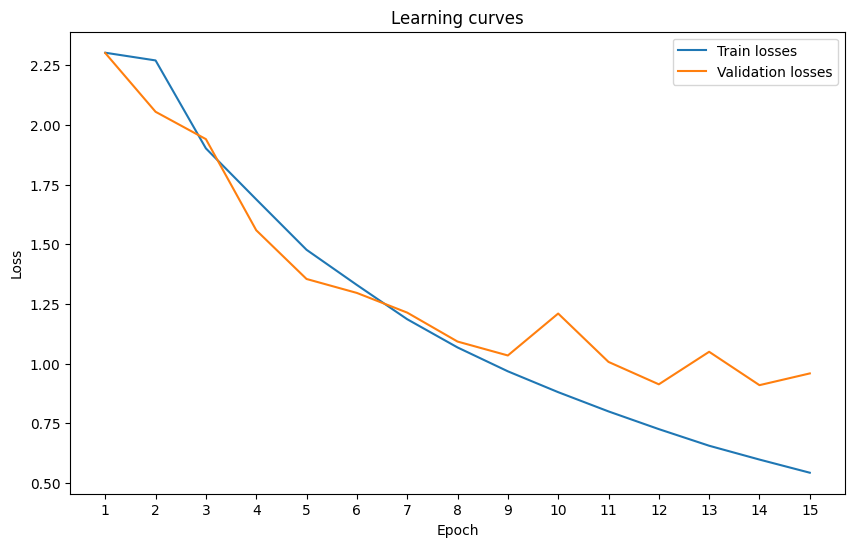

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
# use matplotlib to plot the training and validation losses in a single graph,
# and label them accordingly
plt.plot(epochs, train_losses, label="Train losses")
plt.plot(epochs, valid_losses, label="Validation losses")

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

# Error analysis

Here we will take a look at the validation samples that the model got wrong. This is often a good idea when trying to improve a models, since it gives you some intuition about the kinds of examples the model finds difficult, which can lead to insights on how to improve models.

We'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about, viewing our model's learned representations in two dimensions with t-SNE, and taking a look at the weights of our model.



**Note**: The code in the previous notebook should help you to easily complete the missing parts in this Section

## Predictions of the model in the validation set

We start by defining a predict function which takes a data loader and produces predictions for all samples.

In addition to the predictions, this function also provides other useful outputs



In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    # save the predictions, images and labels in this list
    y_preds = []
    images = []
    labels = []
    
    with torch.no_grad():

        for batch, targets in iterator:
            batch = batch.to(device)
            # predict probabilities of each class
            predictions, _ = model(batch)
            # apply a softmax to the predictions
            predictions = nn.Softmax(dim=1)(predictions)
            
            # top_pred = y_preds.argmax(1, keepdim = True)

            # save
            images.append(batch.cpu())
            labels.append(targets.cpu())
            y_preds.append(predictions.cpu())

    # stack
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    y_preds = torch.cat(y_preds, dim = 0)

    return images, labels, y_preds

In [ ]:
# compute predictions on the validation set
# images, labels, probs =
images, labels, probs = get_predictions(model, valid_loader, device)

# ...and then get the predicted labels from the model's predictions. Use torch.argmax
pred_labels = torch.argmax(probs, dim=1)


In [ ]:
# convert to numpy
y_true = np.array(labels)
y_pred = np.array(pred_labels)

# calculate the number of errors
num_errors = np.sum(y_true != y_pred)

print(f'Validation errors {num_errors} (out of {len(valid_set)})')

Validation errors 3072 (out of 10000)


## Confusion matrix
 
We'll examine our model by plotting a confusion matrix, which helps us understand which classes the model is more frequently mixing

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

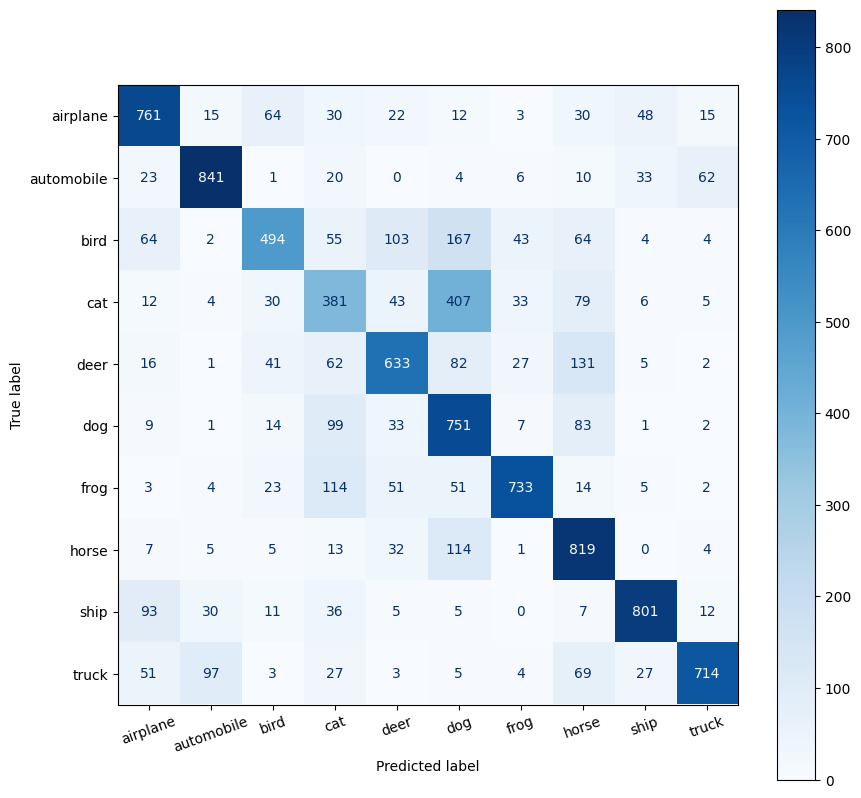

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes) 

## Analysis of samples predicted wrongly
Here we will find the samples that the model is predicting wrongly and we will. Especifically, we will look at those samples that the model is predicting wrongly with a high score for the wrong class

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

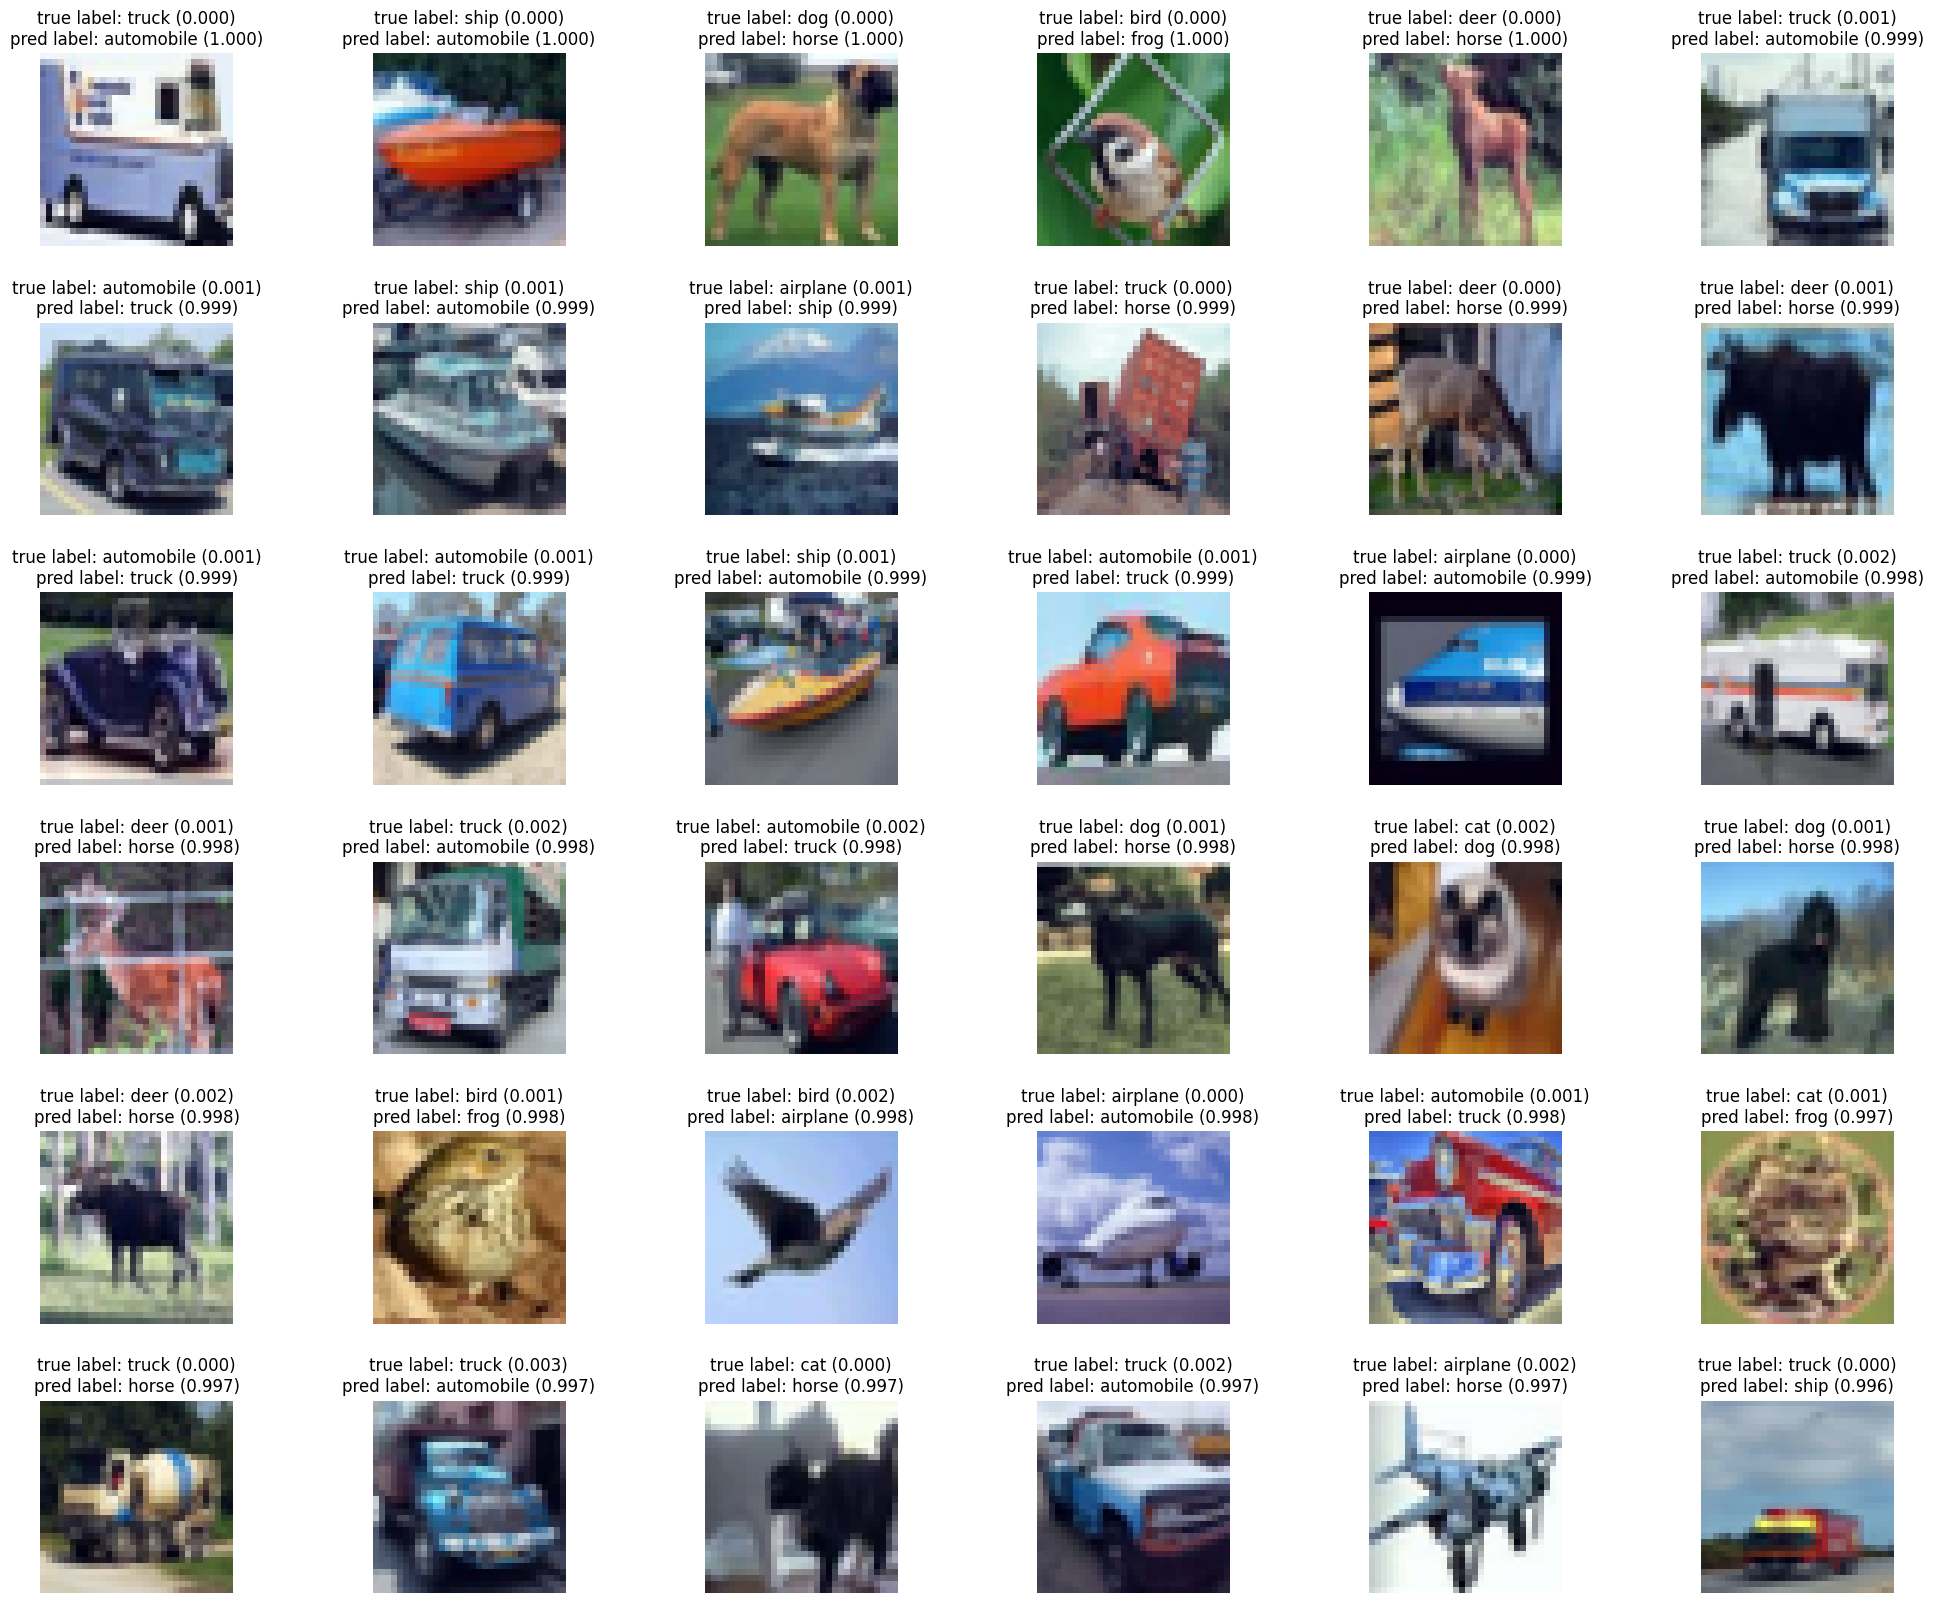

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

# T-SNE representations: final  layer

In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, interm_feats = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(interm_feats.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels
    # return outputs, labels

In [ ]:
outputs, intermediates, labels = get_representations(model, valid_loader, device)

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

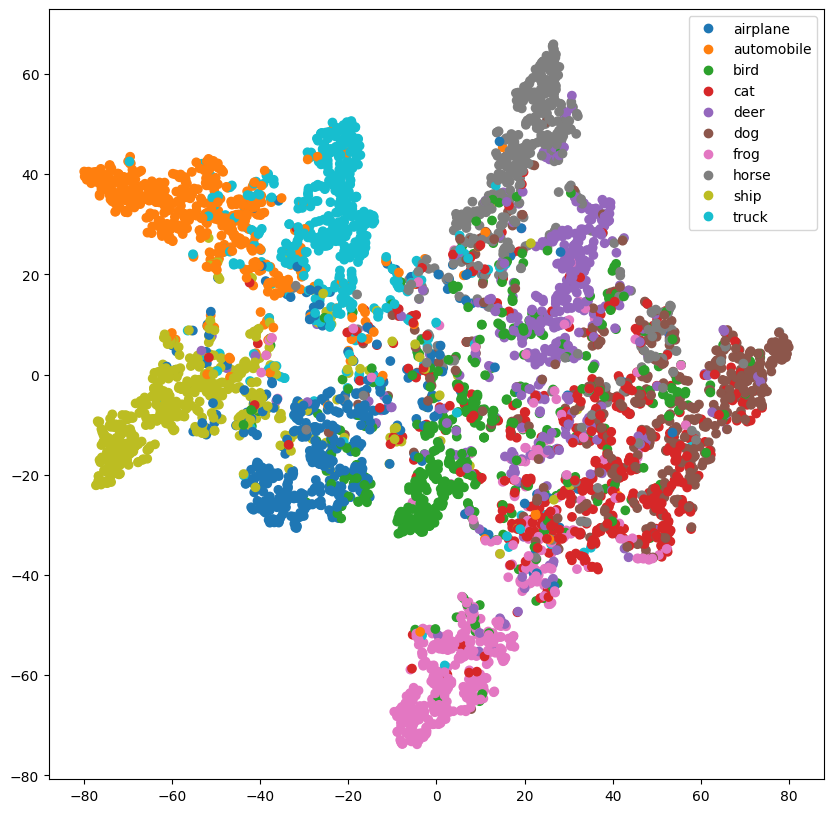

In [ ]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES)

# Visualization of filters 




Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

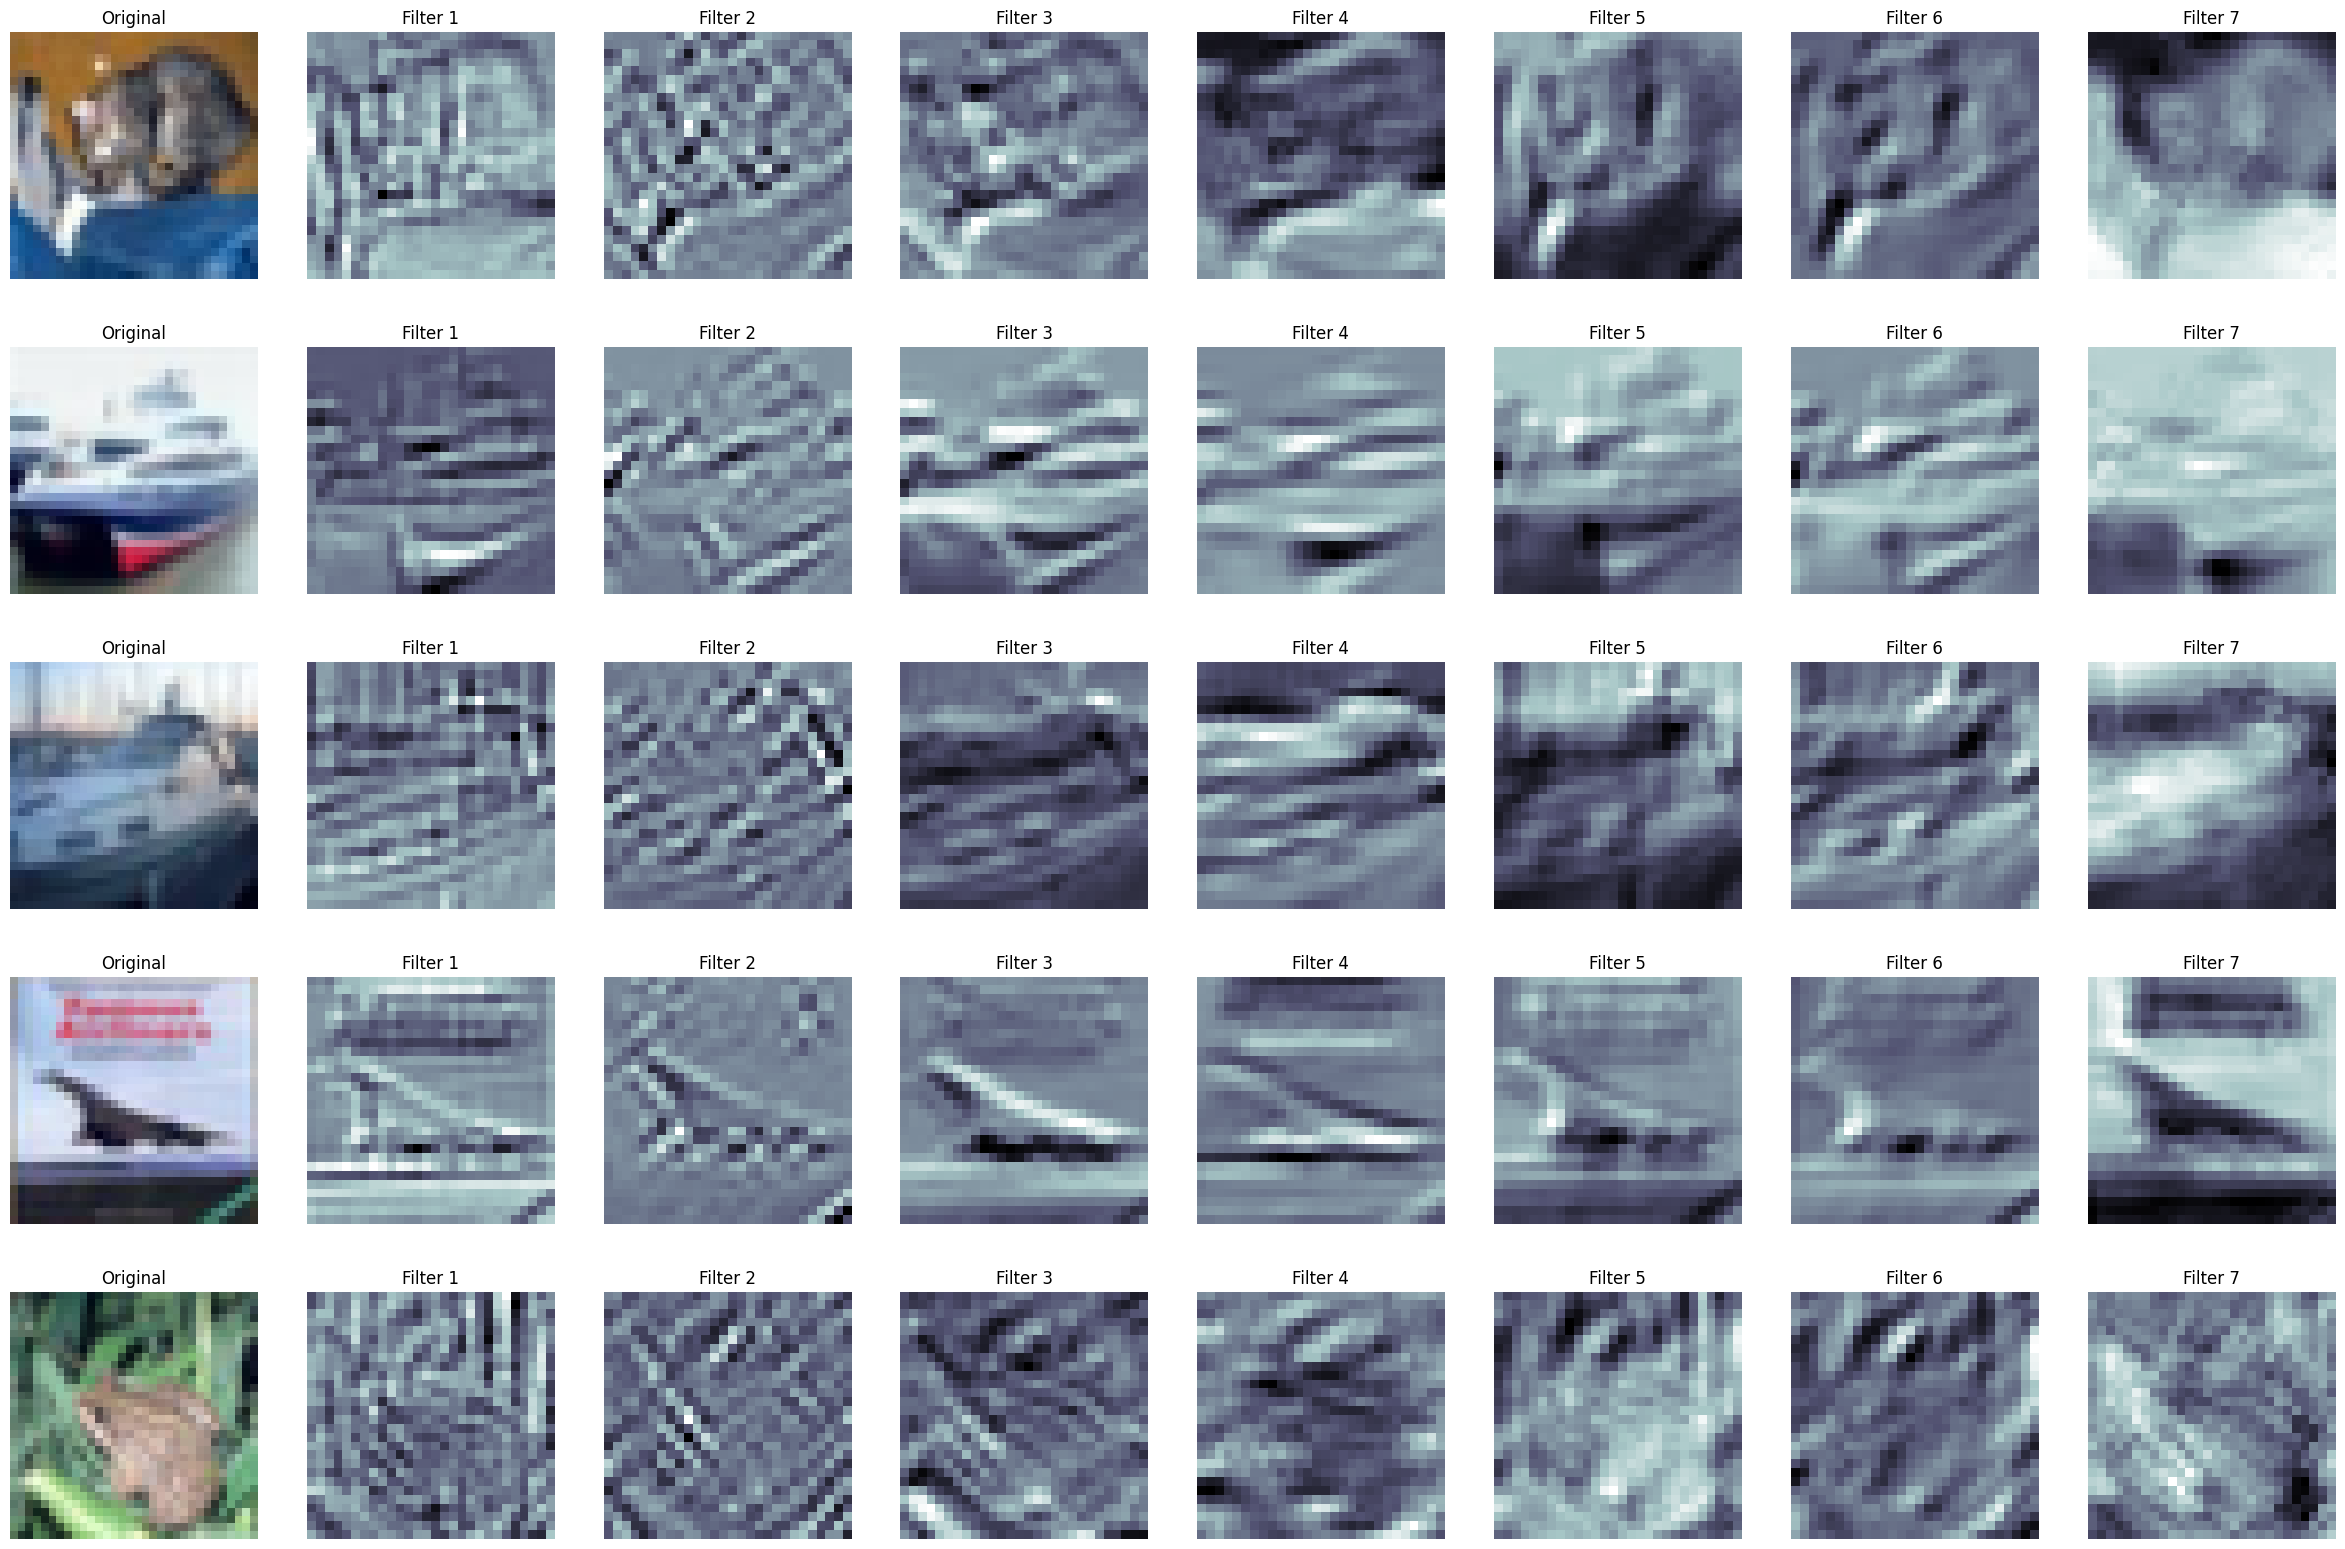

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = []
images = [image for image, label in [valid_set[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

Finally, we can plot the actual filters our model has learned.

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

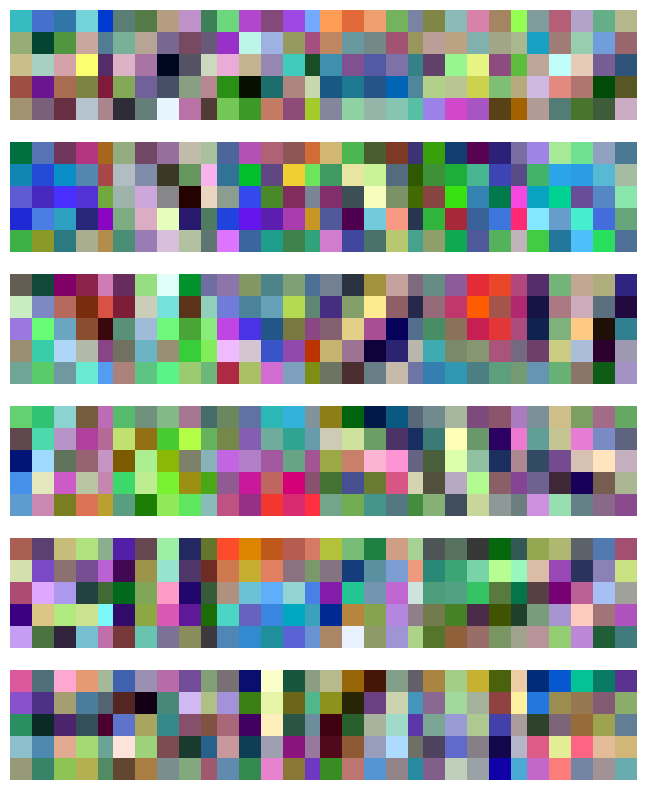

In [ ]:
plot_filters(filters)

Sadly, there is nothing really interpretable here.

Can we learn interesting looking filters? Or are we doomed to just look at colorful blocks?

Well, we can take a *pre-trained* AlexNet model and view the filters of that. This pre-trained version of AlexNet was trained by people at PyTorch and was not trained on the CIFAR10 dataset, but on the [ILSVRC](https://arxiv.org/abs/1409.0575) dataset, usually just called the ImageNet dataset. ImageNet is a dataset with over 1 million images in 1,000 classes. Torchvision provides ways of downloading different models pre-trained on ImageNet, such as AlexNet and [many others](https://pytorch.org/docs/stable/torchvision/models.html).  

First, we can import the model making sure to pass `pretrained = True` to get a pre-trained version. Torchvision will then import the model, download the weights for it and load them into the new model.

We can see that this is similar to our AlexNet model but has considerably more parameters.

One interesting thing is that they use much larger filters in the first convolutional layer - 11x11 instead of 5x5.

In [ ]:
import torchvision.models as models

model = models.alexnet(pretrained = True)

print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can then get the learned values of these filters the same way we did for our version of AlexNet and then plot them.

As we can see the patterns are much more interesting. So how come it learned these interesting looking filters? Is it just because the filters are bigger? Is it because models can only do well on ImageNet if they learn these types of filters? Do these more interesting looking filters imply that they perform better? Or are these filters showing how the model has overfit to patterns on the images within ImageNet?

It is difficult to answer these questions, and network interpretability is one of the still open questions in the research community. 

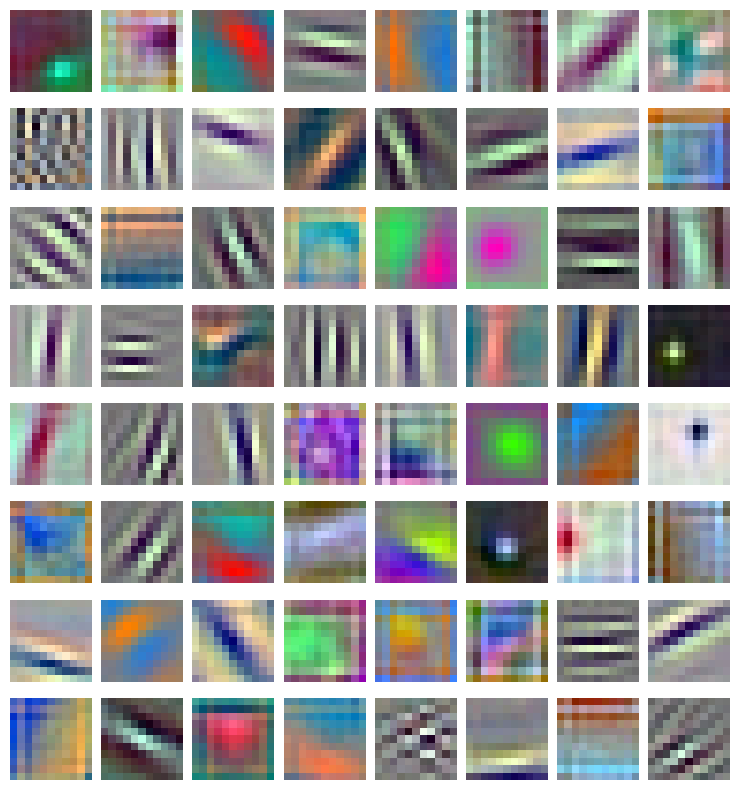

In [ ]:
filters_imagenet = model.features[0].weight.data

plot_filters(filters_imagenet)